# CUSTOMER SEGMENTATION USING RFM ANALYSIS AND K-MEANS CLUSTERING

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

# Load the dataset
data = pd.read_csv(r"C:\Users\natal\OneDrive\Plocha\vš\6.semestr\HAN\08 individual project\online_retail_II.csv")

df = pd.DataFrame(data)

## Data understanding

In [68]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


## Data preparation 

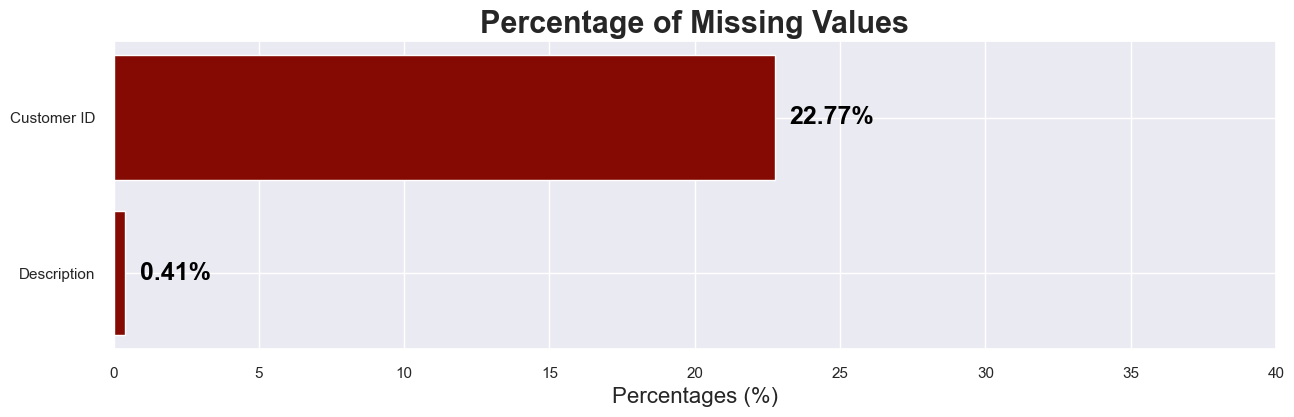

In [71]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#850a03')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

The chart highlights a critical issue with the Customer ID column, where a substantial portion of data is missing, potentially impacting customer-centric analyses. On the other hand, the Description column is nearly complete, suggesting reliable product information.

In [72]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['Customer ID'].isnull() | df['Description'].isnull()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [73]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['Customer ID', 'Description'])

In [74]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

In [75]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price','Customer ID', 'Country'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
365,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
394,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
362,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
368,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom


In [76]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 26479 duplicate rows that need to be removed.


In [77]:
# Getting the number of rows in the dataframe
print("Number of rows in the dataframe:")
df.shape[0]

Number of rows in the dataframe:


797885

In [78]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Valid')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('Customer ID', axis=1)

,Quantity,Price
count,18390.000000,18390.000000
mean,-25.719195,24.240567
std,825.979381,428.241509
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


In [79]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction_Status
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Valid
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Valid
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Valid
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Valid
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Valid


In [80]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.30%


In [81]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 4646


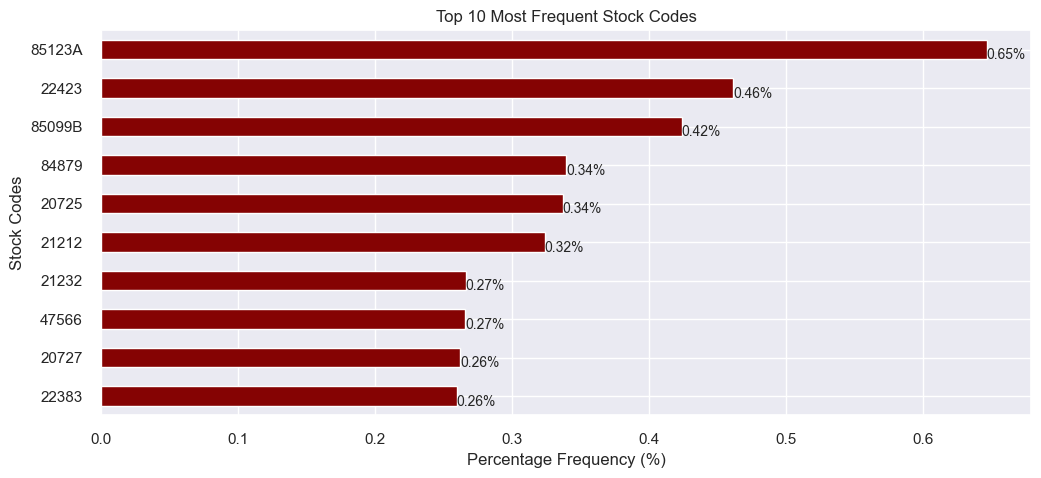

In [82]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#850303')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [83]:
# Extracting the stock codes from the top_10_stock_codes index
top_10_stock_codes_list = top_10_stock_codes.index.tolist()

# Filtering the DataFrame to get descriptions for the top 10 most frequent stock codes
top_10_stock_codes_descriptions = df[df['StockCode'].isin(top_10_stock_codes_list)][['StockCode', 'Description']].drop_duplicates()

# Display the descriptions
print("Descriptions for the Top 10 Most Frequent Stock Codes:")
print(top_10_stock_codes_descriptions)

Descriptions for the Top 10 Most Frequent Stock Codes:
        StockCode                         Description
4           21232      STRAWBERRY CERAMIC TRINKET BOX
15          84879       ASSORTED COLOUR BIRD ORNAMENT
102        85123A  WHITE HANGING HEART T-LIGHT HOLDER
161        85099B         JUMBO BAG RED WHITE SPOTTY 
166         20725                LUNCH BAG RED SPOTTY
246         21212    PACK OF 72 RETRO SPOT CAKE CASES
860         20727             LUNCH BAG  BLACK SKULL.
1329        47566                       PARTY BUNTING
66495       22383              LUNCHBAG SUKI  DESIGN 
78737       22383             LUNCH BAG SUKI  DESIGN 
124243      22423            REGENCY CAKESTAND 3 TIER
148394     85099B            RED RETROSPOT JUMBO BAG 
198107     85099B             JUMBO BAG RED RETROSPOT
353196      21212     PACK OF 72 RETROSPOT CAKE CASES
353377      20725             LUNCH BAG RED RETROSPOT
622918      22383              LUNCH BAG SUKI DESIGN 
943240      21232      STRA

In [84]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    4633
0       8
1       2
3       2
4       1
Name: count, dtype: int64


In [85]:
# Getting the number of rows in the dataframe
df.shape[0]

797885

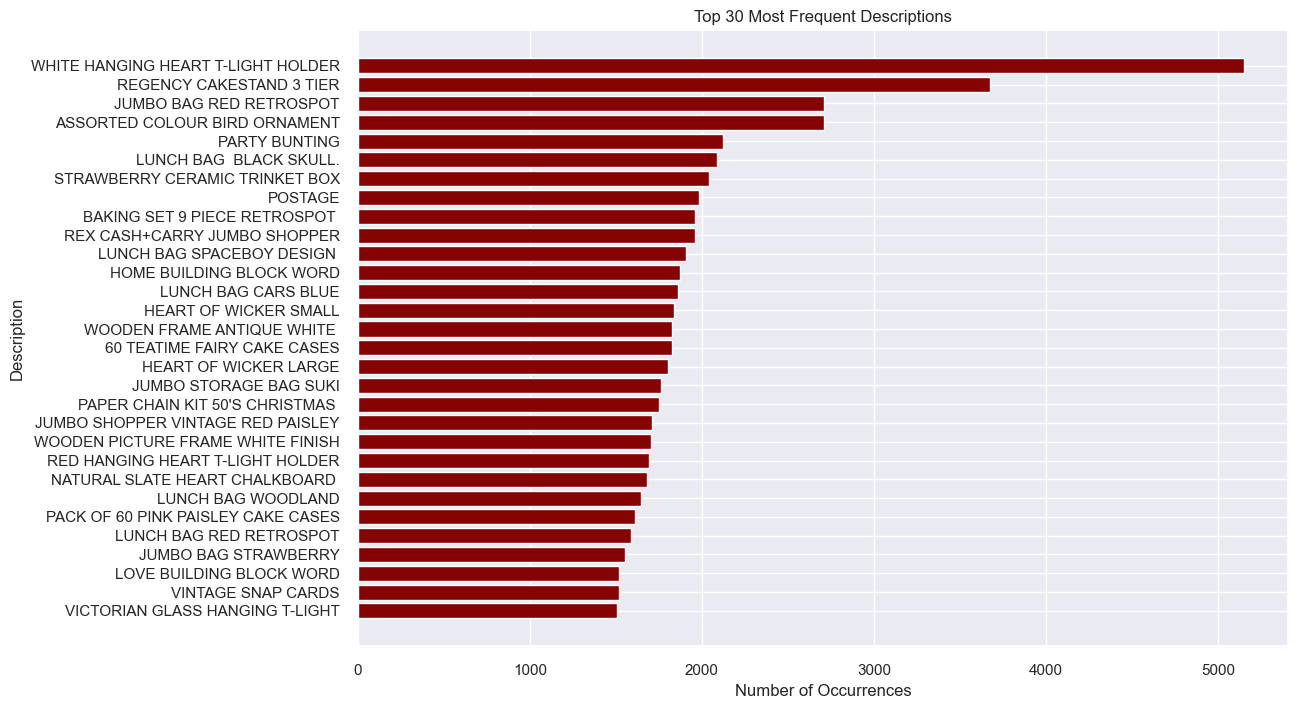

In [86]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#850303')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [87]:
df['Price'].describe()

count    797885.000000
mean          3.702732
std          71.392549
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: Price, dtype: float64

In [88]:
df[df['Price']==0].describe()[['Quantity']]

,Quantity
count,70.000000
mean,210.757143
std,1497.681768
min,1.000000
25%,1.000000
50%,5.000000
75%,12.000000
max,12540.000000


In [89]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['Price'] > 0]

In [90]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [91]:
# Getting the number of rows in the dataframe
df.shape[0]

797815

## Modeling

In [92]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('Customer ID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)


In [93]:
customer_data.head()

,Customer ID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [94]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
total_transactions.rename(columns={'Invoice': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('Customer ID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='Customer ID')
customer_data = pd.merge(customer_data, total_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,17,53
1,12347.0,2,8,2967
2,12348.0,75,5,2714
3,12349.0,18,5,1619
4,12350.0,310,1,197


In [95]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['Price'] * df['Quantity']
total_spend = df.groupby('Customer ID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='Customer ID')
customer_data = pd.merge(customer_data, average_transaction_value[['Customer ID', 'Average_Transaction_Value']], on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,17,53,-51.74,-3.043529
1,12347.0,2,8,2967,4921.53,615.191250
2,12348.0,75,5,2714,2019.40,403.880000
3,12349.0,18,5,1619,4404.54,880.908000
4,12350.0,310,1,197,334.40,334.400000


In [96]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('Customer ID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,17,53,-51.74,-3.043529,30
1,12347.0,2,8,2967,4921.53,615.191250,126
2,12348.0,75,5,2714,2019.40,403.880000,25
3,12349.0,18,5,1619,4404.54,880.908000,139
4,12350.0,310,1,197,334.40,334.400000,17


In [97]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('Customer ID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('Customer ID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['Customer ID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['Customer ID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

C:\Users\natal\AppData\Local\Temp\ipykernel_24524\1963172450.py:6: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,17,53,-51.74,-3.043529,30,8.695652,0,13
1,12347.0,2,8,2967,4921.53,615.191250,126,1.819005,1,14
2,12348.0,75,5,2714,2019.40,403.880000,25,7.260000,0,14
3,12349.0,18,5,1619,4404.54,880.908000,139,4.005587,3,9
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16


In [98]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.897538
Germany           0.021723
EIRE              0.020070
France            0.017418
Netherlands       0.006433
Name: proportion, dtype: float64

In [99]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['Customer ID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('Customer ID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['Customer ID', 'Is_UK']], on='Customer ID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,17,53,-51.74,-3.043529,30,8.695652,0,13,1
1,12347.0,2,8,2967,4921.53,615.191250,126,1.819005,1,14,0
2,12348.0,75,5,2714,2019.40,403.880000,25,7.260000,0,14,0
3,12349.0,18,5,1619,4404.54,880.908000,139,4.005587,3,9,0
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16,0


In [100]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    5272
0     519
Name: count, dtype: int64

In [101]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancellation_frequency.rename(columns={'Invoice': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='Customer ID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['Invoice']

# Display the first few rows of the customer_data dataframe
customer_data.head()

# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['Customer ID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()


# Display the first few rows of the customer_data dataframe
customer_data.head()

C:\Users\natal\AppData\Local\Temp\ipykernel_24524\3566781865.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,17,53,-51.74,-3.043529,30,8.695652,0,13,1,5.0,0.294118
1,12347.0,2,8,2967,4921.53,615.191250,126,1.819005,1,14,0,0.0,0.000000
2,12348.0,75,5,2714,2019.40,403.880000,25,7.260000,0,14,0,0.0,0.000000
3,12349.0,18,5,1619,4404.54,880.908000,139,4.005587,3,9,0,1.0,0.200000
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16,0,0.0,0.000000


In [102]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['Customer ID'] = customer_data['Customer ID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,17,53,-51.74,-3.043529,30,8.695652,0,13,1,5,0.294118
1,12347.0,2,8,2967,4921.53,615.19125,126,1.819005,1,14,0,0,0.0
2,12348.0,75,5,2714,2019.4,403.88,25,7.26,0,14,0,0,0.0
3,12349.0,18,5,1619,4404.54,880.908,139,4.005587,3,9,0,1,0.2
4,12350.0,310,1,197,334.4,334.4,17,0.0,2,16,0,0,0.0
5,12351.0,375,1,261,300.93,300.93,21,0.0,0,15,0,0,0.0
6,12352.0,36,13,658,1889.21,145.323846,70,3.178571,1,14,0,3,0.230769
7,12353.0,204,2,212,406.76,203.38,23,8.869565,2,12,0,0,0.0
8,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0
9,12355.0,214,2,543,947.61,473.805,35,10.382353,4,11,0,0,0.0


In [103]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer ID                     5791 non-null   string 
 1   Days_Since_Last_Purchase        5791 non-null   Int64  
 2   Total_Transactions              5791 non-null   Int64  
 3   Total_Products_Purchased        5791 non-null   Int64  
 4   Total_Spend                     5791 non-null   Float64
 5   Average_Transaction_Value       5791 non-null   Float64
 6   Unique_Products_Purchased       5791 non-null   Int64  
 7   Average_Days_Between_Purchases  5791 non-null   Float64
 8   Day_Of_Week                     5791 non-null   Int32  
 9   Hour                            5791 non-null   Int32  
 10  Is_UK                           5791 non-null   Int64  
 11  Cancellation_Frequency          5791 non-null   Int64  
 12  Cancellation_Rate               57

In [104]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Outlier_Scores,Is_Outlier
0,12346.0,325,17,53,-51.74,-3.043529,30,8.695652,0,13,1,5,0.294118,1,0
1,12347.0,2,8,2967,4921.53,615.19125,126,1.819005,1,14,0,0,0.0,1,0
2,12348.0,75,5,2714,2019.4,403.88,25,7.26,0,14,0,0,0.0,1,0
3,12349.0,18,5,1619,4404.54,880.908,139,4.005587,3,9,0,1,0.2,1,0
4,12350.0,310,1,197,334.4,334.4,17,0.0,2,16,0,0,0.0,1,0


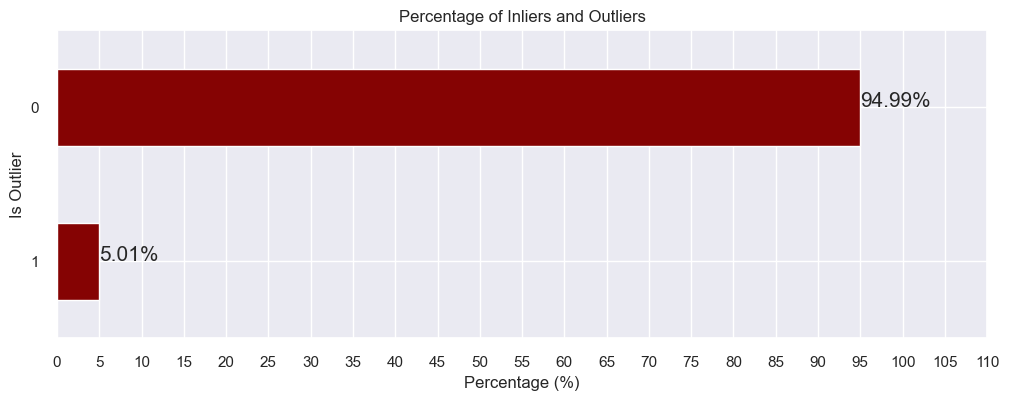

In [105]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#850303')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [106]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [107]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

5501

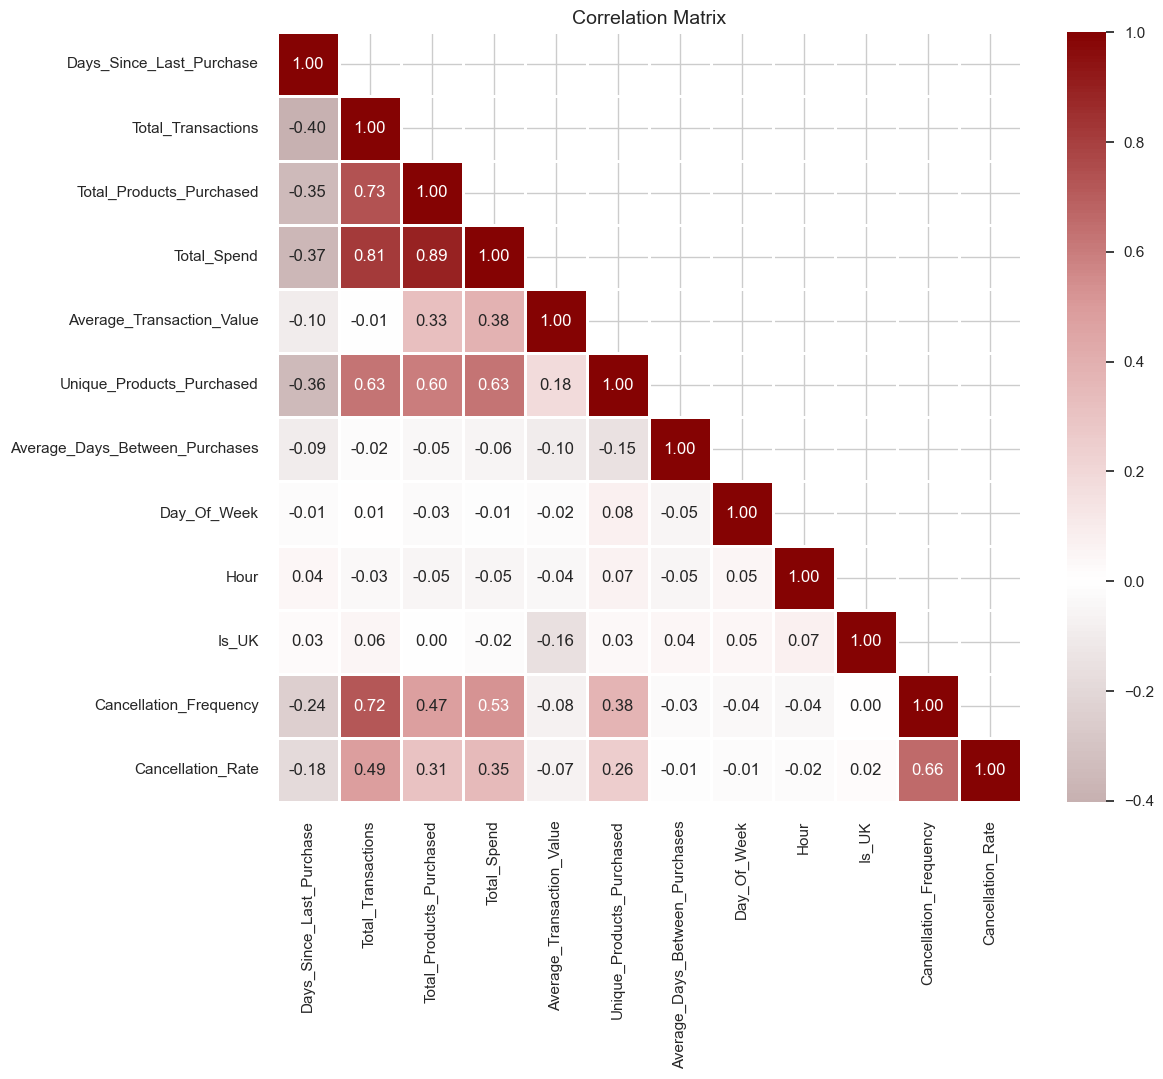

In [108]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['Customer ID']).corr()

# Define a custom colormap
colors = ['#fa9d9d', '#ba9e9e', 'white', '#db9c9c', '#850303']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### The correlation matrix reveals several important relationships:

Higher transaction activity (more transactions, products purchased, and total spend) is associated with more cancellations.

Recent customer activity (shorter Days_Since_Last_Purchase) is associated with higher transaction activity and lower cancellations.
There are strong interdependencies among Total_Transactions, Total_Products_Purchased, Total_Spend, and Unique_Products_Purchased, suggesting that these metrics collectively indicate customer engagement.

Variables such as Day_Of_Week and Hour do not show significant correlations with other factors, suggesting they may not be strong indicators of customer behavior in this dataset.

In [109]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer ID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,0.593866,1.780047,-0.672565,-0.772810,-1.267246,-0.511556,0.272930,0,0.185041,1,2.529161,-0.071738
1,12347.0,-0.958805,0.355382,1.544644,1.597707,1.557971,0.626663,-0.234862,1,0.631102,0,-0.575707,-0.453218
2,12348.0,-0.607892,-0.119506,1.352141,0.214402,0.592318,-0.570838,0.166917,0,0.631102,0,-0.575707,-0.453218
3,12349.0,-0.881893,-0.119506,0.518975,1.351283,2.772246,0.780797,-0.073398,3,-1.599202,0,0.045266,-0.193812
4,12350.0,0.521761,-0.752691,-0.562998,-0.588756,0.274807,-0.665689,-0.369182,2,1.523223,0,-0.575707,-0.453218


## RFM

Calculation Recency

In [110]:
from datetime import datetime, timedelta

this_date = datetime(2021, 12, 31)

# Convert Days_Since_Last_Purchase to LastPurchaseDate
customer_data_cleaned['LastPurchaseDate'] = customer_data_cleaned['Days_Since_Last_Purchase'].apply(
    lambda x: this_date - timedelta(days=x))

# Create df_recency DataFrame with Customer ID and Recency
df_recency = customer_data_cleaned[['Customer ID', 'Days_Since_Last_Purchase']].copy()
df_recency = df_recency.rename(columns={'Days_Since_Last_Purchase': 'Recency'})


# Display the resulting DataFrame
df_recency.head(20)


,Customer ID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
5,12351.0,375
6,12352.0,36
7,12353.0,204
8,12354.0,232
9,12355.0,214


Calculation Frequency

In [111]:
# Drop duplicates and calculate frequency
frequency_df = customer_data_cleaned.drop_duplicates().groupby(
    by=['Customer ID'], as_index=False)['Total_Transactions'].sum()
frequency_df.columns = ['Customer ID', 'Frequency']

frequency_df.head(20)

,Customer ID,Frequency
0,12346.0,17
1,12347.0,8
2,12348.0,5
3,12349.0,5
4,12350.0,1
5,12351.0,1
6,12352.0,13
7,12353.0,2
8,12354.0,1
9,12355.0,2


Calculation Monetary

In [112]:
#Calculating Monetary Value 
monetary_df =customer_data_cleaned.groupby(by='Customer ID', as_index=False)['Total_Spend'].sum()
monetary_df.columns = ['Customer ID', "Monetary"]
monetary_df.head(20)

,Customer ID,Monetary
0,12346.0,-51.74
1,12347.0,4921.53
2,12348.0,2019.4
3,12349.0,4404.54
4,12350.0,334.4
5,12351.0,300.93
6,12352.0,1889.21
7,12353.0,406.76
8,12354.0,1079.4
9,12355.0,947.61


In [113]:
# Ensure all Customer ID columns are of type string
df_recency['Customer ID'] = df_recency['Customer ID'].astype(str)
frequency_df['Customer ID'] = frequency_df['Customer ID'].astype(str)
monetary_df['Customer ID'] = monetary_df['Customer ID'].astype(str)

# Merge the dataframes
rf_df = df_recency.merge(frequency_df, on='Customer ID')
rfm_df = rf_df.merge(monetary_df, on='Customer ID')

rfm_df.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,325,17,-51.74
1,12347.0,2,8,4921.53
2,12348.0,75,5,2019.4
3,12349.0,18,5,4404.54
4,12350.0,310,1,334.4


Rankiong customer based on RFM

In [114]:
#Normalizing rank
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

#Normalizing 
rfm_df['R_rank_norm']= (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm']= (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm']= (rfm_df['M_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank','F_rank', 'M_rank'], 
              inplace=True)

rfm_df.head(20)

,Customer ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,325,17,-51.74,29.025501,93.501182,0.381749
1,12347.0,2,8,4921.53,97.522769,77.395019,92.910380
2,12348.0,75,5,2019.4,54.744991,62.724959,76.386112
3,12349.0,18,5,4404.54,81.466302,62.724959,91.365206
4,12350.0,310,1,334.4,30.218579,11.861480,25.595346
5,12351.0,375,1,300.93,25.774135,11.861480,22.350482
6,12352.0,36,13,1889.21,69.599271,88.683876,74.659153
7,12353.0,204,2,406.76,38.834244,31.539720,31.376113
8,12354.0,232,1,1079.4,36.684882,11.861480,59.534630
9,12355.0,214,2,947.61,37.896175,31.539720,55.353572


Calculation RFM score for each customer

In [115]:
#Calculating RFMTL Score
rfm_df['RFM_Score'] = 0.22*rfm_df['R_rank_norm']+0.21*rfm_df['F_rank_norm']+0.18*rfm_df['M_rank_norm']
rfm_df["RFM_Score"] *=0.10
rfm_df=rfm_df.round(0)
rfm_df[['Customer ID', 'RFM_Score']].head(10)

,Customer ID,RFM_Score
0,12346.0,3.0
1,12347.0,5.0
2,12348.0,4.0
3,12349.0,5.0
4,12350.0,1.0
5,12351.0,1.0
6,12352.0,5.0
7,12353.0,2.0
8,12354.0,2.0
9,12355.0,2.0


Creating customer segments

In [116]:
rfm_df['CustomerSegment']= np.where(rfm_df['RFM_Score']==10,"Champion",
                                   (np.where(rfm_df['RFM_Score']==9, "Loyal users",
                                   (np.where(rfm_df['RFM_Score']==8, "Potential Loyalist",
                                   (np.where(rfm_df['RFM_Score']==7, "Promising",
                                   (np.where(rfm_df['RFM_Score']==6, "New user",
                                   (np.where(rfm_df['RFM_Score']==5, "Needing Attention",
                                   (np.where(rfm_df['RFM_Score']==4, "Cannot lose them",
                                   (np.where(rfm_df['RFM_Score']==3, "At risk",
                                   (np.where(rfm_df['RFM_Score']==2, "About to sleep",
                                   (np.where(rfm_df['RFM_Score']==1, "Hibernating","N/A")) )))))))))))))))))
rfm_df[['Customer ID', 'RFM_Score', 'CustomerSegment','Frequency']].head(10)

,Customer ID,RFM_Score,CustomerSegment,Frequency
0,12346.0,3.0,At risk,17
1,12347.0,5.0,Needing Attention,8
2,12348.0,4.0,Cannot lose them,5
3,12349.0,5.0,Needing Attention,5
4,12350.0,1.0,Hibernating,1
5,12351.0,1.0,Hibernating,1
6,12352.0,5.0,Needing Attention,13
7,12353.0,2.0,About to sleep,2
8,12354.0,2.0,About to sleep,1
9,12355.0,2.0,About to sleep,2


In [117]:
rfm_m =rfm_df.groupby('CustomerSegment')['Monetary'].sum()
rfm_m.head(10)


CustomerSegment
About to sleep        516486.0
At risk              1006593.0
Cannot lose them     1795208.0
Hibernating           214059.0
N/A                     8442.0
Needing Attention    3198043.0
New user             1895456.0
Name: Monetary, dtype: Float64

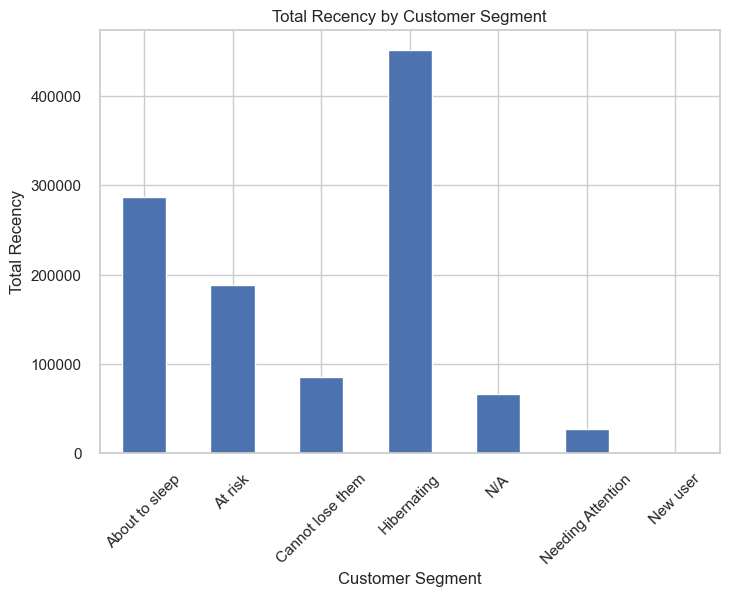

In [118]:
import matplotlib.pyplot as plt

# Calculate the sum of 'Recency' for each 'CustomerSegment'
recency_sum_by_segment = rfm_df.groupby('CustomerSegment')['Recency'].sum()

# Plot the bar chart
recency_sum_by_segment.plot(kind='bar')

# Set labels and title
plt.xlabel('Customer Segment')
plt.ylabel('Total Recency')
plt.title('Total Recency by Customer Segment')
plt.xticks(rotation=45)

# Display the plot
plt.show()


## Total Recency by Customer Segment

Hibernating: This segment has the highest total recency, indicating that customers in this segment have not purchased for the longest period.

About to sleep: This segment also shows high recency, suggesting that these customers have not purchased recently but not as long as the Hibernating segment.
At risk: This segment has a significant total recency, indicating these customers might soon become inactive if no action is taken.

N/A and Cannot lose them: Both segments have lower recency values, indicating more recent purchases compared to the previous segments.
Needing Attention and New user: These segments have the lowest recency values, indicating the most recent purchases.

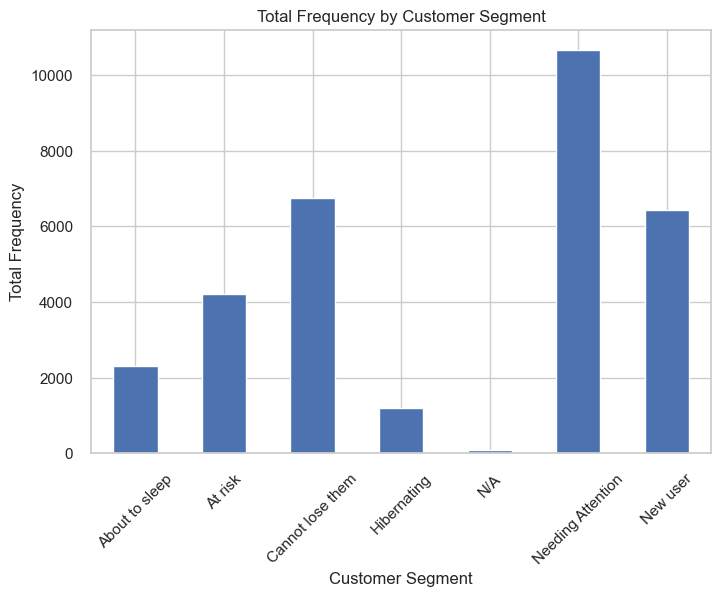

In [119]:
# Calculate the sum of 'Frequency' for each 'CustomerSegment'
frequency_sum_by_segment  = rfm_df.groupby('CustomerSegment')['Frequency'].sum()

# Plot the bar chart
frequency_sum_by_segment .plot(kind='bar')

# Set labels and title
plt.xlabel('Customer Segment')
plt.ylabel('Total Frequency')
plt.title('Total Frequency by Customer Segment')
plt.xticks(rotation=45)

# Display the plot
plt.show()


## Total Frequency by Customer Segment

Needing Attention: This segment has the highest total frequency, indicating very active customers who make frequent purchases.

New user: This segment also shows high frequency, suggesting these new customers are making frequent purchases.

Cannot lose them: This segment shows a significant frequency, indicating loyal customers.
At risk and About to sleep: Both segments show moderate frequency, indicating a need for re-engagement.
Hibernating: This segment has low frequency, indicating very infrequent purchases.

N/A: This segment has almost negligible frequency.

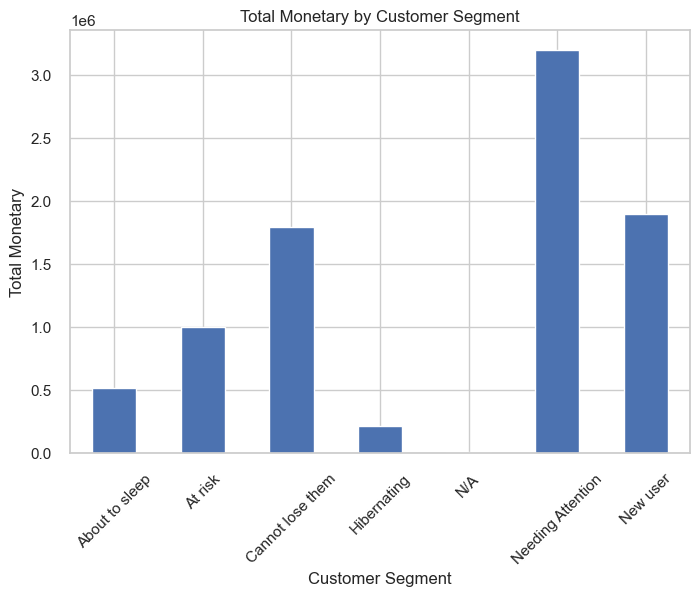

In [120]:
# Calculate the sum of 'Monetary' for each 'CustomerSegment'
monetary_sum_by_segment  = rfm_df.groupby('CustomerSegment')['Monetary'].sum()

# Plot the bar chart
monetary_sum_by_segment .plot(kind='bar')

# Set labels and title
plt.xlabel('Customer Segment')
plt.ylabel('Total Monetary')
plt.title('Total Monetary by Customer Segment')
plt.xticks(rotation=45)

# Display the plot
plt.show()


## Total Monetary by Customer Segment

Needing Attention: This segment has the highest total monetary value, indicating these customers have the highest total spend.

Cannot lose them: This segment also shows a high monetary value, indicating significant spending by loyal customers.

New user: This segment has a considerable monetary value, indicating that new users are contributing significantly to the total spend.

At risk: This segment has a moderate monetary value, indicating that these customers have spent a significant amount but may need re-engagement to avoid losing them.
About to sleep and Hibernating: These segments show lower monetary values, indicating lower total spending and a need for re-engagement.

N/A: This segment shows negligible monetary value.

<Axes: xlabel='Segment'>

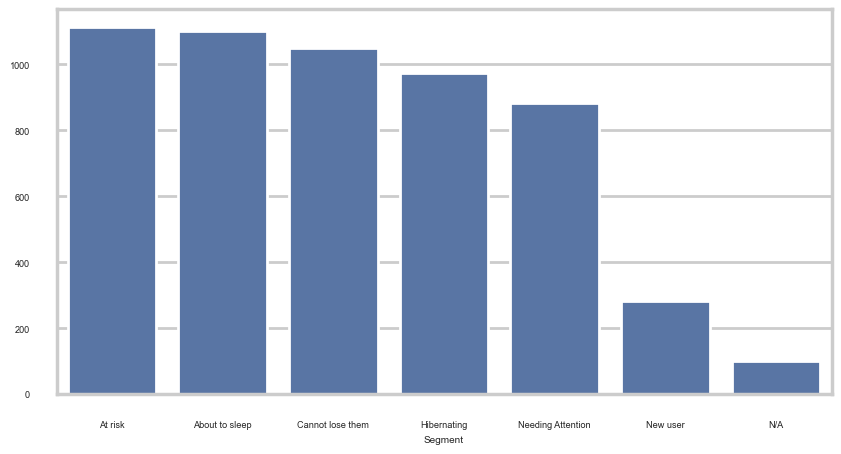

In [121]:
s=rfm_df.CustomerSegment.value_counts()
s=rfm_df.CustomerSegment.value_counts().rename_axis('Segment').rename('Number of customers')
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale =0.3)
sns.barplot(x=s.index, y=s.values, order=s.index)

## Customer Count by Segment

At risk: This segment has the highest number of customers, indicating a large group that needs re-engagement to avoid losing them.

About to sleep: This segment also has a high number of customers, indicating a significant group that is close to becoming inactive.

Cannot lose them: This segment has a substantial number of customers, indicating a loyal customer base that should be maintained.

Hibernating: This segment has a significant number of customers who have not engaged recently.

Needing Attention: This segment has a notable number of customers that are very active and should be prioritized for engagement.

New user: This segment has a lower number of customers, indicating new users who are still engaging.

N/A: This segment has the fewest customers, likely indicating data gaps or undefined segments.

## K-means

In [122]:
#K-means construction
rfm_df.describe()

,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
count,5501.0,5501.0,5501.0,5501.000000,5501.000000,5501.000000,5501.000000
mean,201.458826,5.754954,1569.584985,50.129613,50.163970,50.008907,3.056899
std,208.047449,6.317849,2098.158864,28.953632,28.515062,28.870679,1.536655
min,0.0,1.0,-10954.0,0.000000,12.000000,0.000000,0.000000
25%,26.0,2.0,328.0,25.000000,32.000000,25.000000,2.000000
50%,100.0,3.0,789.0,50.000000,45.000000,50.000000,3.000000
75%,379.0,7.0,1918.0,75.000000,74.000000,75.000000,4.000000
max,738.0,50.0,21441.0,100.000000,100.000000,100.000000,6.000000


In [123]:
import plotly.express as px

#Check for outliers
fig = px.box(rfm_df,y='R_rank_norm')
fig.show()
fig1 =px.box(rfm_df,y='F_rank_norm')
fig1.show()
fig2 =px.box(rfm_df,y='M_rank_norm')
fig2.show()

In [124]:
#Transform data to meet K-means requirement for construction
rfm1=rfm_df[['R_rank_norm','F_rank_norm','M_rank_norm']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[-0.7298405 ,  1.53743363, -1.73232689],
       [ 1.65349681,  0.94120327,  1.48922721],
       [ 0.16822863,  0.45019004,  0.90034098],
       ...,
       [-1.62790963, -1.33850103, -0.58919479],
       [-1.28249843, -0.18111269,  0.45001621],
       [ 0.58272208,  0.94120327,  1.38530611]])

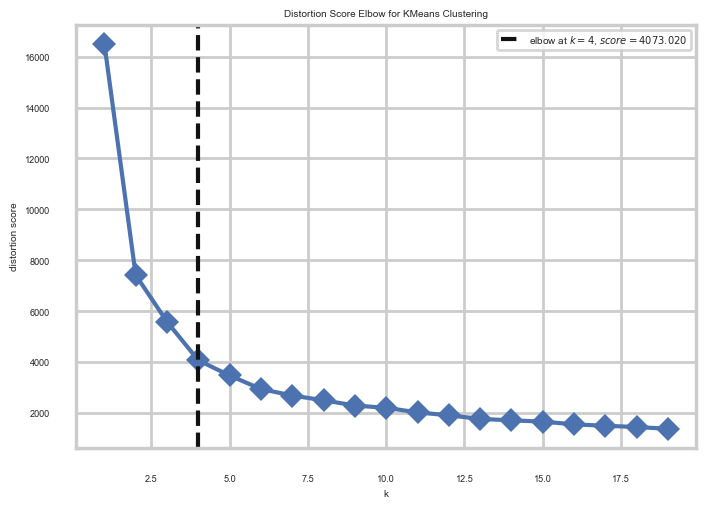

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [125]:
# Elbow Method to check the number of k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 20), timings=False)  # Disable fit time display
visualizer.fit(x_scaled)  
visualizer.show()

Based on the elbow method, using k=4 clusters is the most appropriate choice for this dataset, as it balances between minimizing the distortion score and avoiding overfitting with too many clusters.

[2 0 2 ... 3 2 0]
 Our cluster centers are as follows
[[ 0.72268367 -0.56400157 -0.5345461 ]
 [-0.52445325  0.36594196  0.37067677]
 [ 0.94418822  1.13678124  1.11710137]
 [-1.06491587 -1.0241503  -1.02937551]]


,R_rank_norm,F_rank_norm,M_rank_norm
cluster_pred,,,
0,1134,1134,1134
1,1233,1233,1233
2,1570,1570,1570
3,1564,1564,1564


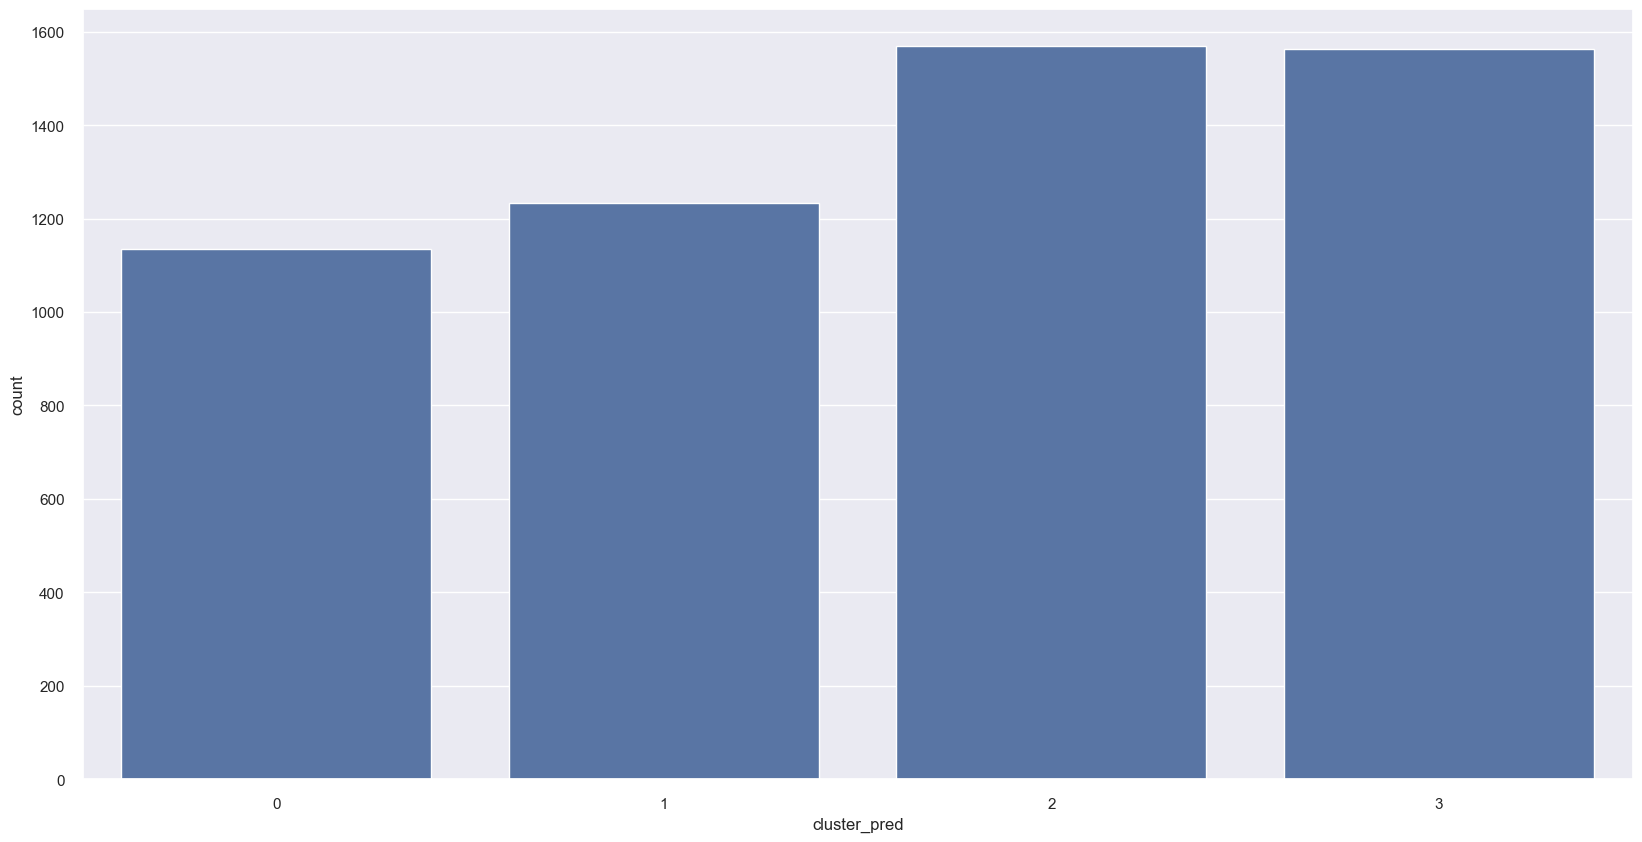

In [126]:
#Apply k to form clusters
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

The distribution of data points across the clusters is relatively balanced, with clusters 2 and 3 having slightly more data points (~1,500 each) compared to clusters 0 and 1. This indicates that the K-Means algorithm has successfully divided the dataset into four clusters of comparable size, suggesting that each cluster is likely capturing a significant segment of the data with its unique characteristics. This balance in cluster sizes is desirable as it indicates that the clustering process has not produced overly small or large clusters, which can be beneficial for subsequent analysis and decision-making.

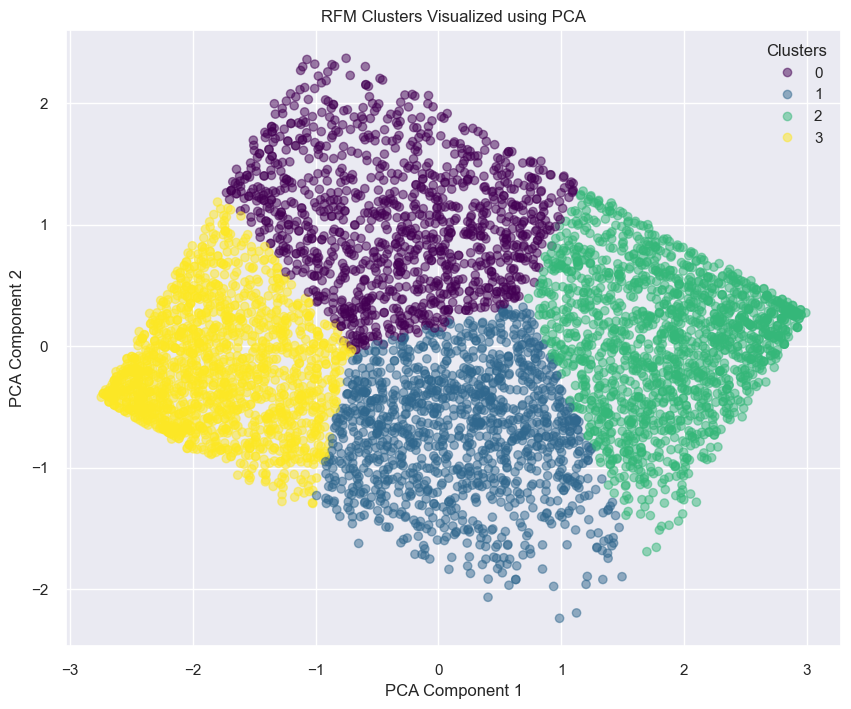

In [127]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(x_scaled)

# Scatter plot of the data points colored by cluster label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters_scaled['cluster_pred'], cmap='viridis', alpha=0.5)
plt.title('RFM Clusters Visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(4), title="Clusters")
plt.show()

The PCA plot effectively shows the separation of the four clusters in the RFM dataset:

Each cluster is visually distinct with minimal overlap, indicating that the K-Means algorithm has successfully grouped similar data points together.

The clear separation between clusters suggests that each cluster represents a unique segment of customers based on their RFM values.

The use of PCA for dimensionality reduction maintains the integrity of the cluster separation, making it easier to visualize the inherent structure of the data.

## Evaluation

In [128]:
#Basic statistice on Clusters
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['CustomerSegment']=rfm_df['CustomerSegment']
rfm1.groupby('cluster').agg({
    'R_rank_norm' : ['mean','min','max'],
    'F_rank_norm' : ['mean','min','max'],
    'M_rank_norm' : ['mean','min','max','count']
})

C:\Users\natal\AppData\Local\Temp\ipykernel_24524\2935907049.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\natal\AppData\Local\Temp\ipykernel_24524\2935907049.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



R_rank_norm              F_rank_norm              M_rank_norm        \
               mean   min    max        mean   min    max        mean   min   
cluster                                                                       
0         71.052028  40.0  100.0   34.082892  12.0   85.0   34.577601   0.0   
1         35.080292   0.0   68.0   60.632603  12.0   95.0   60.772912   0.0   
2         77.549045  32.0  100.0   82.647134  32.0  100.0   82.303822  36.0   
3         19.299233   0.0   54.0   20.962916  12.0   77.0   20.292839   0.0   

                      
           max count  
cluster               
0         84.0  1134  
1         99.0  1233  
2        100.0  1570  
3         78.0  1564

In [129]:
#The nature of clusters will be determioned(Homogeneous or herogeneous)
rfm1.groupby(['cluster','CustomerSegment']).size()

cluster  CustomerSegment  
0        About to sleep       381
         At risk              495
         Cannot lose them     258
1        About to sleep       229
         At risk              617
         Cannot lose them     387
2        Cannot lose them     406
         Needing Attention    883
         New user             281
3        About to sleep       491
         Hibernating          973
         N/A                  100
dtype: int64

Cluster 0 and Cluster 1: Both clusters have a significant presence of "At risk" and "About to sleep" customers, indicating a need for strategies to prevent churn and re-engage these segments.

Cluster 2: Dominated by "Hibernating" customers, highlighting a segment that has become inactive and requires targeted re-engagement efforts.

Cluster 3: Contains a mix of "Needing Attention," "Cannot lose them," and "New user" segments, focusing on maintaining and nurturing the engagement of valuable and new customers.

C:\Users\natal\AppData\Local\Temp\ipykernel_24524\3236430789.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\natal\AppData\Local\Temp\ipykernel_24524\3236430789.py:8: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



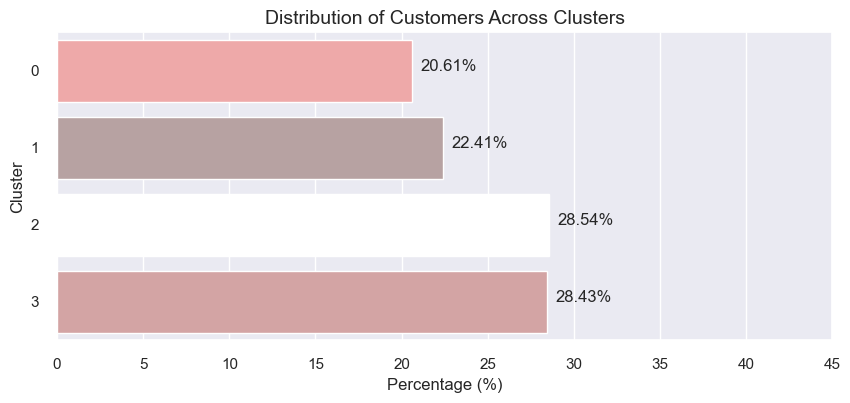

In [130]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (rfm1['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

The distribution of customers across the four clusters is relatively balanced, with Clusters 2 and 3 being slightly larger than Clusters 0 and 1. This balanced distribution suggests that the K-Means clustering algorithm has effectively divided the customers into four distinct groups, each representing a significant portion of the total customer base.

In [131]:
# Compute number of customers
print('Number of customers: ')
print(len(rfm1))



Number of customers: 
5501


### Marketing Strategies for Each Customer Cluster

Based on the distribution of customers across the clusters and their unique characteristics, here are tailored marketing strategies for each cluster:

#### Cluster 0: About to Sleep, At Risk, Cannot Lose Them
**Characteristics**:
- **About to Sleep**: Customers who have not purchased recently and are at risk of becoming inactive.
- **At Risk**: Customers who are on the verge of becoming inactive but have shown significant engagement in the past.
- **Cannot Lose Them**: Loyal customers who are currently less active.

**Strategies**:
1. **Re-engagement Campaigns**:
   - **Personalized Email Campaigns**: Send personalized emails with special offers, discounts, and reminders about products they have previously purchased.
   - **Win-Back Offers**: Offer exclusive win-back discounts or incentives to encourage these customers to make a purchase.

2. **Loyalty Programs**:
   - **Reward Points**: Implement a loyalty program where customers earn points for purchases that can be redeemed for discounts or free products.
   - **Exclusive Access**: Provide early access to new products or special events to make them feel valued and encourage re-engagement.

3. **Feedback and Surveys**:
   - **Customer Feedback**: Send out surveys to understand why their activity has decreased and gather insights on how to better serve their needs.
   - **Product Recommendations**: Use feedback to recommend products that match their preferences.

#### Cluster 1: About to Sleep, At Risk, Cannot Lose Them
**Characteristics**:
- Similar to Cluster 0, this cluster also contains customers who need re-engagement.

**Strategies**:
1. **Segmentation-Based Offers**:
   - **Targeted Promotions**: Create segmented promotions based on past purchase behavior to entice them to return.
   - **Limited-Time Offers**: Use urgency in promotions to encourage immediate action.

2. **Enhanced Customer Service**:
   - **Proactive Support**: Reach out to offer help or support, addressing any potential issues they might have faced.
   - **Follow-Up Calls**: Personal follow-up calls to high-value customers to re-establish a connection.

3. **Content Marketing**:
   - **Engaging Content**: Share engaging and relevant content through newsletters or social media to keep the brand top-of-mind.
   - **Educational Webinars**: Host webinars on topics of interest to the customers to re-engage them with valuable content.

#### Cluster 2: About to Sleep, Hibernating, N/A
**Characteristics**:
- **About to Sleep**: Similar to previous clusters, needing re-engagement.
- **Hibernating**: Customers who have been inactive for a long period.
- **N/A**: Possibly undefined or newly identified segments.

**Strategies**:
1. **Reactivation Campaigns**:
   - **Exclusive Reactivation Offers**: Provide special discounts exclusively for reactivating their accounts.
   - **Personalized Outreach**: Use personalized messaging to remind them of the brand and what they’re missing out on.

2. **Re-engagement Content**:
   - **Nostalgic Reminders**: Send reminders of past favorite purchases or popular items they might like.
   - **Incentivized Surveys**: Offer incentives for completing surveys to understand why they became inactive.

3. **Social Proof and Testimonials**:
   - **Success Stories**: Share testimonials and success stories from other customers to build trust and encourage re-engagement.
   - **User-Generated Content**: Encourage them to share their experiences or photos using your products on social media.

#### Cluster 3: Cannot Lose Them, Needing Attention, New User
**Characteristics**:
- **Cannot Lose Them**: Loyal customers who need continuous engagement.
- **Needing Attention**: Very active customers who require ongoing engagement to maintain their activity.
- **New User**: Recently acquired customers who are still in the onboarding phase.

**Strategies**:
1. **Loyalty and VIP Programs**:
   - **VIP Programs**: Offer exclusive VIP programs for top customers with additional perks.
   - **Referral Programs**: Encourage them to refer friends with referral bonuses and discounts.

2. **Personalized Experience**:
   - **Custom Recommendations**: Use purchase history to offer personalized product recommendations.
   - **Exclusive Previews**: Provide sneak peeks or early access to new products.

3. **Onboarding and Engagement**:
   - **Welcome Series**: For new users, create a welcome series of emails or messages to introduce them to the brand and products.
   - **Tutorials and Guides**: Provide detailed guides or tutorials to help new users get the most out of their purchases.

4. **Regular Communication**:
   - **Monthly Newsletters**: Send regular newsletters with updates, offers, and new product launches.
   - **Social Media Engagement**: Actively engage with these customers on social media platforms to build a community.

